In [39]:
import os
import torch
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
import numpy as np
import librosa
from IPython import display

import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html
# Dataset:
#   https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html
#   https://pytorch.org/audio/stable/generated/torchaudio.datasets.SPEECHCOMMANDS.html#torchaudio.datasets.SPEECHCOMMANDS


# tutorial https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

In [2]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("../data/", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]
    
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


In [3]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

In [4]:
# all waveforms come in 1 second arrays
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [7]:
"""
check the max value occuring in the dataset to see if we need to normalize the data.
When we later want to capture audio samples ourselves, we need to check again.
"""
total_max = 0
for i in tqdm(range(len(train_set))):
    waveform = train_set[i][0]
    current_max = waveform.max()
    if current_max > total_max:
        total_max = current_max
if total_max <= 1:
    print(f"The max value is {total_max} and the data obviously comes normalized.")
else:
    print("We should normalize the data.")

100%|██████████| 84843/84843 [00:32<00:00, 2614.58it/s]

The max value is 0.999969482421875 and the data obviously comes normalized.


In [51]:
display.display(display.Audio(waveform, rate=16000))
print(f"Label: {label}")

Label: zero


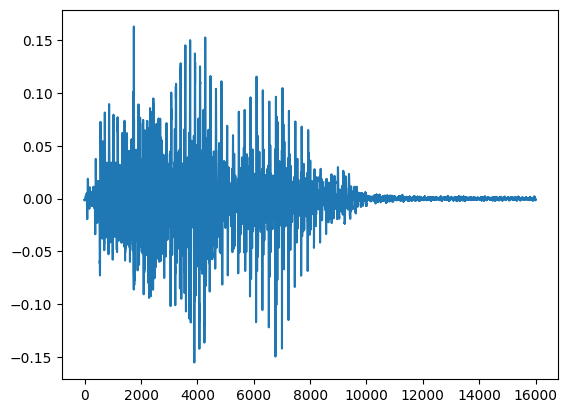

In [8]:
plt.plot(waveform.t().numpy())

In [10]:
# store indices
no_array = []
for i in tqdm(range(len(train_set))):
    label = train_set[i][2]
    if label == "no":
        no_array.append(i)


100%|██████████| 84843/84843 [00:33<00:00, 2497.34it/s]


In [71]:
# we cut the sample into 30ms pieces, which in our case is equal to 480 samples of one audio file

# Apply a pre-emphasis filter to the audio data
pre_emphasis = 0.97
emphasized_audio_data = np.append(waveform[0], waveform[1:] - pre_emphasis * waveform[:-1])

window_size_ms = 30
window_length_samples = 480
window_stride_ms = 20
window_stride_samples = 320
hann_window = np.hanning(window_length_samples)
n_iterations = int(sample_rate / window_stride_samples - 1)
n_frequency_buckets = 40
# values for the frequency limits
lower_freq = 10
upper_freq = 8000
# empty array in shape of final array
mfcc_array = np.zeros((n_iterations, n_frequency_buckets))

for slice in range(n_iterations):
    # set start and end point of our window
    start_ind = 0
    end_ind = window_length_samples
    # apply hanning window
    window = emphasized_audio_data[start_ind:end_ind] * hann_window
    # create the spectrogram
    spectrogram = np.abs(librosa.stft(emphasized_audio_data, n_fft=480, hop_length=160))
    
    # scale down by non linear Mel function
    mfcc_window = librosa.feature.mfcc(S=spectrogram, sr=sample_rate, n_mfcc=n_frequency_buckets, 
                                       n_fft=window_length_samples, hop_length=160, 
                                       fmin=lower_freq, fmax=upper_freq)
    # array has shape [40,101] now and needs to be averaged to [40,1]
    

    # increase starting point by window size
    start_ind += window_stride_samples
    
    mfcc_array[slice] = mfcc_window


ValueError: could not broadcast input array from shape (40,101) into shape (40,)

In [70]:
mfcc_window.shape

(40, 101)

In [64]:
spectrogram = np.abs(librosa.stft(hany, n_fft=480, hop_length=160))

In [65]:
spectrogram.shape

(241, 4)

In [27]:
audio_data = waveform

# Apply a pre-emphasis filter to the audio data
pre_emphasis = 0.97
emphasized_audio_data = np.append(audio_data[0], audio_data[1:] - pre_emphasis * audio_data[:-1])
# Convert the audio data to a spectrogram
# in the original preprocessing it's set to 480 and hop_l to 160, but cgpt suggests to use 640 and 320
spectrogram = np.abs(librosa.stft(emphasized_audio_data, n_fft=480, hop_length=160))

# Apply the microfrontend preprocessing method
window_size_ms = 30.0
window_stride_ms = 20.0
# feature_bin_count = 40
dct_coefficient_count = 10
lower_frequency_limit = 10
upper_frequency_limit = 8000
sample_rate = 16000

# Apply the window function to the spectrogram
window_length_samples = int(round(window_size_ms * sample_rate / 1000))
window_stride_samples = int(round(window_stride_ms * sample_rate / 1000))
window = np.hanning(480)
num_frames = 1 + int(np.floor((spectrogram.shape[1] - 480) / 160))
# set up the array
mfccs = np.zeros((num_frames, dct_coefficient_count))

ValueError: negative dimensions are not allowed

In [53]:
int(np.ceil(1-30)/20)

-1

In [34]:
duration = len(waveform) / sample_rate
print(duration + 1)



1.0000625


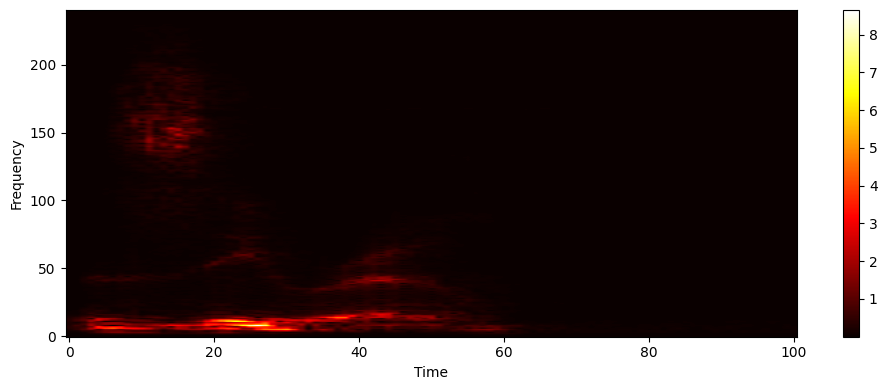

In [21]:
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, cmap='hot', aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:




# Apply the microfrontend preprocessing method
window_size_ms = 30.0
window_stride_ms = 20.0
# feature_bin_count = 40
dct_coefficient_count = 10
lower_frequency_limit = 10
upper_frequency_limit = 8000
sample_rate = 16000

# Apply the window function to the spectrogram
window_length_samples = int(round(window_size_ms * sample_rate / 1000))
window_stride_samples = int(round(window_stride_ms * sample_rate / 1000))
window = np.hanning(window_length_samples)
num_frames = 40
# set up the array
mfccs = np.zeros((num_frames, dct_coefficient_count))

# populate the array
for frame in range(num_frames):
    start = frame * window_stride_samples
    end = start + window_length_samples
    windowed_spec = spectrogram[:, start:end] * window
    # Mel-Frequency Cepstral Coefficients
    mfcc = librosa.feature.mfcc(
        S=windowed_spec,
        sr=sample_rate,
        n_mfcc=dct_coefficient_count,
        n_fft=480,
        hop_length=180,
        fmin=lower_frequency_limit,
        fmax=upper_frequency_limit
    )
    mfccs[frame, :] = mfcc

# Quantize the MFCC data
quantized_mfccs = (np.clip(mfccs, -80.0, 16.0) + 80.0) * (255.0 / 96.0)
quantized_mfccs = np.round(quantized_mfccs).astype(np.uint8)

# Reshape the MFCC data to the required shape (num_frames, num_dct_coeffs)
num_dct_coeffs = quantized_mfccs.shape[1]
reshaped_mfccs = quantized_mfccs.reshape((1, num_frames, num_dct_coeffs))

# Apply the window stride
window_stride = 20
start = 0
end = window_stride * reshaped_mfccs.shape[1]
stride_mfccs = reshaped_mfccs[:, start:end:window_stride, :]

# Convert the MFCC data to a tensor
mfcc_tensor = np.array(stride_mfccs, dtype=np.float32)

# Normalize the data to have zero mean and unit variance
mean = np.mean(mfcc_tensor)
std = np.std(mfcc_tensor)
normalized_mfcc_tensor = (mfcc_tensor - mean) / std